In [20]:
import numpy as np
import matplotlib.pyplot as plt


## Unpickling the data

In [13]:
import pickle as pkl

with open('sensor_data_with_truth.pkl', 'rb') as f:
    e = pkl.load(f)
print(e)


{'accel': [array([ 8.72009724,  5.2068139 , -3.72348853]), array([1.70335214, 0.20476843, 1.67055904]), array([-7.19273626, -4.40462241, -5.7226635 ]), array([-2.98299097,  3.68216957, -8.15705925]), array([-6.29759141, -4.85607671, -6.73124271]), array([-4.20926616,  3.65728688,  2.75935112]), array([ 1.41738128, -3.65866483,  2.65120366]), array([-0.47214615,  2.93604692,  4.71946103]), array([ -5.9847814 , -10.58466187,   1.04681343]), array([ 5.56402482, -8.62821787, -2.91445921]), array([-1.61931895, -5.30881159,  0.99204492]), array([13.17680003, -4.26034103, -4.52570283]), array([ 2.78384373,  0.48168184, -0.08556308]), array([-5.178931  , -5.27055912,  5.26577006]), array([9.00684724, 1.59709983, 0.26061793]), array([ 8.24305756,  0.16419666, -2.35338332]), array([-0.45509106,  5.1259961 ,  1.81831502]), array([ 3.22104127, -1.43475712, -8.00921081]), array([-0.93169631, -7.79283573, -4.77522528]), array([ 0.61110023, -1.15839799,  4.39334596]), array([7.61050417, 4.46888173, 0

In [17]:
e.keys()


dict_keys(['accel', 'gyro', 'pressure', 'temp', 'gps', 'sensor_pos', 'rocket_pos'])

(5000, 3)


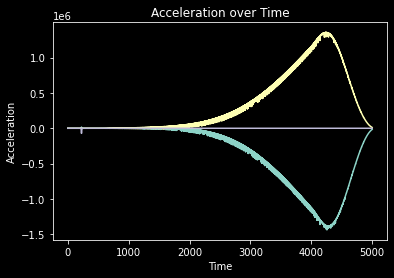

In [28]:
accel_sense = np.array(e['accel'])
print(accel_sense.shape)


# Plot accel over time
plt.plot(accel_sense)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acceleration over Time')
plt.show()


(5000, 3)


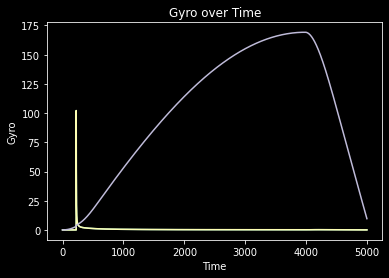

In [29]:
gyro_sense = np.array(e['gyro'])
print(gyro_sense.shape)

# Plot gyro over time
plt.plot(gyro_sense)
plt.xlabel('Time')
plt.ylabel('Gyro')
plt.title('Gyro over Time')
plt.show()


(5000,)


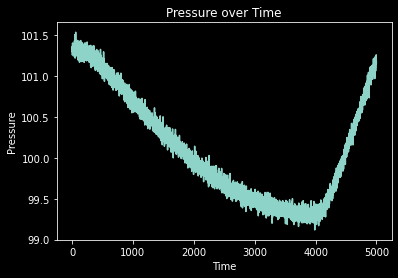

In [32]:
pressure_sense = np.array(e['pressure'])
print(pressure_sense.shape)

# Plot pressure over time
plt.plot(pressure_sense)
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.title('Pressure over Time')
plt.show()


(5000,)


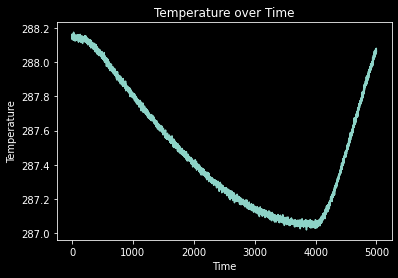

In [33]:
temp_sense = np.array(e['temp'])
print(temp_sense.shape)

# Plot temp over time
plt.plot(temp_sense)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show() 


(5000, 3)


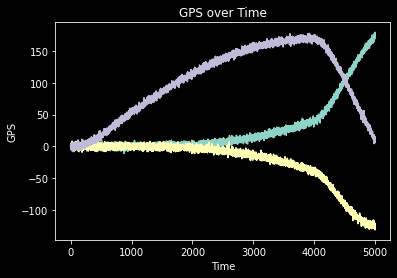

In [34]:
gps_sense = np.array(e['gps'])
print(gps_sense.shape)

# Plot gps over time
plt.plot(gps_sense)
plt.xlabel('Time')
plt.ylabel('GPS')
plt.title('GPS over Time')
plt.show() 


(5000, 3)


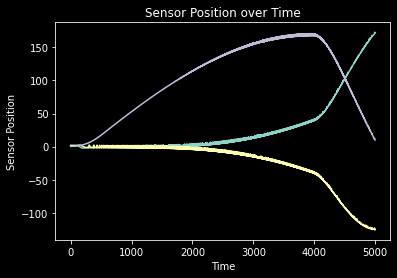

In [35]:
sensor_pos = np.array(e['sensor_pos'])
print(sensor_pos.shape)

# Plot sensor_pos over time
plt.plot(sensor_pos)
plt.xlabel('Time')
plt.ylabel('Sensor Position')
plt.title('Sensor Position over Time')
plt.show() 


(5000, 3)


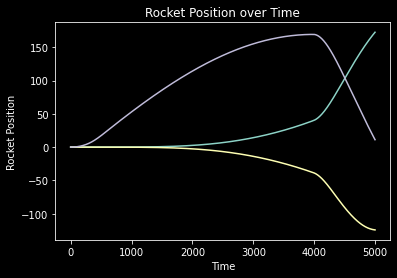

In [36]:
rocket_pos = np.array(e['rocket_pos'])
print(rocket_pos.shape)

# Plot rocket_pos over time
plt.plot(rocket_pos)
plt.xlabel('Time')
plt.ylabel('Rocket Position')
plt.title('Rocket Position over Time')
plt.show()


## Filtering the Data

### Evo Model